In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso, Ridge

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.options.display.max_columns = None

In [6]:
data = pd.read_csv('input/train.csv')

In [7]:
data = data.drop('Healthcare_1', axis=1)

### train_test_split 

In [8]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)

In [9]:
train.shape, valid.shape

((7000, 19), (3000, 19))

### prepare data

In [10]:
def add_mean_column(df, source_df, feat):
    new_feat = 'Mean_' + feat
    data_stat1 = source_df.groupby([feat, 'Rooms'], as_index=False)[['Price']]\
        .mean().rename(columns={'Price': new_feat})
    df = pd.merge(df, data_stat1, on=[feat, 'Rooms'], how='left')
    df[new_feat] = df[new_feat].fillna(source_df[feat].mean())
    return df
    
def add_median_column(df, source_df, feat):
    new_feat = 'Med_' + feat
    data_stat1 = source_df.groupby([feat, 'Rooms'], as_index=False)[['Price']]\
        .median().rename(columns={'Price': new_feat})
    df = pd.merge(df, data_stat1, on=[feat, 'Rooms'], how='left')
    df[new_feat] = df[new_feat].fillna(source_df[feat].mean())
    return df

In [11]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
9069,14604,23,1.0,41.681380,22.796166,8.0,14,17.0,2015,0.075779,B,B,6,1437,3,0,2,B,88504.384965
2603,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977,0.014073,B,B,2,475,0,0,0,B,207007.956663
7738,235,87,1.0,39.710131,19.538663,8.0,4,17.0,1986,0.100456,B,B,43,7227,0,1,6,A,182126.280899
1579,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,1,10,B,524365.550705
5058,10773,77,3.0,79.195825,44.421062,10.0,16,17.0,1984,0.298205,B,B,16,4048,3,1,3,B,322048.433990


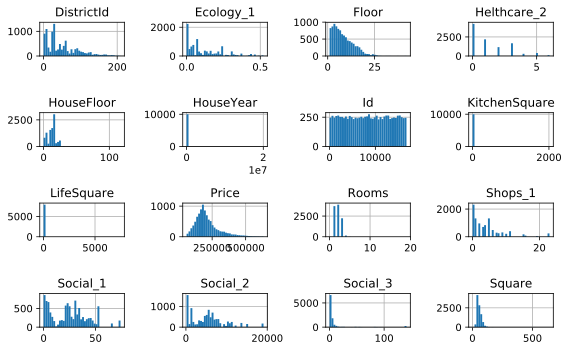

In [12]:
feats1 = list(filter(lambda s: s[0:5] != 'Mean_' and s[0:4] != 'Med_', data.columns))
data1 = pd.DataFrame(data, columns=feats1)

data1.hist(bins=40, figsize=(8, 5), zorder=2)
plt.tight_layout()
plt.xlabel('', fontsize=4);

In [13]:
try:
    feats2 = list(filter(lambda s: s[0:5] == 'Mean_', data.columns))
    data2 = pd.DataFrame(data, columns=feats2)

    data2.hist(bins=40, figsize=(10, 3), zorder=2)
    plt.tight_layout()
    plt.xlabel('', fontsize=4);
except:
    pass
plt.show()

<Figure size 720x216 with 0 Axes>

In [14]:
try:
    feats3 = list(filter(lambda s: s[0:4] == 'Med_', data.columns))
    data3 = pd.DataFrame(data, columns=feats3)

    data3.hist(bins=40, figsize=(10, 3), zorder=2)
    plt.tight_layout()
    plt.xlabel('', fontsize=4);
except:
    pass
plt.show()

<Figure size 720x216 with 0 Axes>

In [15]:
def print_unique():
    for feat in data.columns:
        nunique = data[feat].nunique()
        print(f'{feat:15} {nunique:5}', end='')
        unique = '[...]'
        if nunique <= 25:
            unique = data[feat].unique()
            unique.sort()
        print('    ', end='')
        print(unique)

In [16]:
def _ab_to_01(df, feat):
    try:
        df[feat] = df[feat].replace(['A', 'B'], [0, 1])
        pd.get_dummies(df)
    except:
        pass
    return df

In [17]:
print_unique()

Id              10000    [...]
DistrictId        205    [...]
Rooms               9    [ 0.  1.  2.  3.  4.  5.  6. 10. 19.]
Square          10000    [...]
LifeSquare       7887    [...]
KitchenSquare      58    [...]
Floor              33    [...]
HouseFloor         44    [...]
HouseYear          97    [...]
Ecology_1         129    [...]
Ecology_2           2    ['A' 'B']
Ecology_3           2    ['A' 'B']
Social_1           51    [...]
Social_2          142    [...]
Social_3           30    [...]
Helthcare_2         7    [0 1 2 3 4 5 6]
Shops_1            16    [ 0  1  2  3  4  5  6  7  8  9 10 11 15 16 19 23]
Shops_2             2    ['A' 'B']
Price           10000    [...]


In [18]:
data.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,0,2,B,95380.220993


In [19]:
feats = [
#     'DistrictId',
    'Rooms',
    'Square',
    'LifeSquare',
    'KitchenSquare',
    'Floor',
    'HouseFloor',
#     'HouseYear',
    'Ecology_1',
    'Ecology_2',
    'Ecology_3',
    'Social_1',
    'Social_2',
    #Social_3',
#     'Helthcare_2',
    #Shops_1',
    'Shops_2',
    
    'Mean_DistrictId',
    'Mean_HouseFloor',
    'Mean_HouseYear',
    'Mean_Social_3',
    'Mean_Helthcare_2',
    'Mean_Shops_1',
    
    'Med_DistrictId',
    'Med_HouseFloor',
    'Med_HouseYear',
    'Med_Social_3',
    'Med_Helthcare_2',
    'Med_Shops_1',
#     'FloorK',
#     'FloorRev',
#    'FloorError',
    ]

#X = pd.DataFrame(data, columns=feats)

def ctgr(df, feat):
    try:
        df[feat] = df[feat].astype('category')
        df = pd.get_dummies(df)
    except:
        pass
    return df

# _ctgr_('DistrictId')
# _ctgr_('Rooms')
# _ctgr_('Floor')
# _ctgr_('FloorRev')
# _ctgr_('HouseFloor')
# _ctgr_('HouseYear')
# _ctgr_('Ecology_2')
# _ctgr_('Ecology_3')
#_ctgr_('Helthcare_2')
# _ctgr_('Shops_1')
# _ctgr_('Shops_2')

# data = pd.get_dummies(data)
# feats = data.columns
# data.head()

# train = pd.get_dummies(train)
# valid = pd.get_dummies(valid)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 19 columns):
Id               7000 non-null int64
DistrictId       7000 non-null int64
Rooms            7000 non-null float64
Square           7000 non-null float64
LifeSquare       5514 non-null float64
KitchenSquare    7000 non-null float64
Floor            7000 non-null int64
HouseFloor       7000 non-null float64
HouseYear        7000 non-null int64
Ecology_1        7000 non-null float64
Ecology_2        7000 non-null object
Ecology_3        7000 non-null object
Social_1         7000 non-null int64
Social_2         7000 non-null int64
Social_3         7000 non-null int64
Helthcare_2      7000 non-null int64
Shops_1          7000 non-null int64
Shops_2          7000 non-null object
Price            7000 non-null float64
dtypes: float64(7), int64(9), object(3)
memory usage: 1011.7+ KB


In [21]:
def prepare(df, source_df):
    feats_mm = ['DistrictId',
                'Floor',
                'HouseFloor',
                'HouseYear',
                'Social_3',
                'Helthcare_2',
                'Shops_1',
               ]
    
    for feat in feats_mm:
        df = add_mean_column(df, source_df, feat)
        df = add_median_column(df, source_df, feat)

    df = _ab_to_01(df, 'Ecology_2')
    df = _ab_to_01(df, 'Ecology_3')
    df = _ab_to_01(df, 'Shops_2')

    df = ctgr(df, 'Helthcare_2')
    
    return df

In [22]:
valid = prepare(valid, train)
train = prepare(train, train)

### Model

In [23]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [24]:
def fillna_life_square(df, source_df):
    df['LifeSquare'] = df['LifeSquare'].fillna(source_df['LifeSquare'].mean())
    return df

In [25]:
fillna_life_square(train, train)
fillna_life_square(valid, train)
pass

In [26]:
model = RF(n_estimators=100, max_depth=11, min_samples_leaf=2)

In [27]:
# feats = ['Square', 'Rooms', 'LifeSquare']

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 39 columns):
Id                  7000 non-null int64
DistrictId          7000 non-null int64
Rooms               7000 non-null float64
Square              7000 non-null float64
LifeSquare          7000 non-null float64
KitchenSquare       7000 non-null float64
Floor               7000 non-null int64
HouseFloor          7000 non-null float64
HouseYear           7000 non-null int64
Ecology_1           7000 non-null float64
Ecology_2           7000 non-null int64
Ecology_3           7000 non-null int64
Social_1            7000 non-null int64
Social_2            7000 non-null int64
Social_3            7000 non-null int64
Shops_1             7000 non-null int64
Shops_2             7000 non-null int64
Price               7000 non-null float64
Mean_DistrictId     7000 non-null float64
Med_DistrictId      7000 non-null float64
Mean_Floor          7000 non-null float64
Med_Floor           7000 non-null

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 39 columns):
Id                  7000 non-null int64
DistrictId          7000 non-null int64
Rooms               7000 non-null float64
Square              7000 non-null float64
LifeSquare          7000 non-null float64
KitchenSquare       7000 non-null float64
Floor               7000 non-null int64
HouseFloor          7000 non-null float64
HouseYear           7000 non-null int64
Ecology_1           7000 non-null float64
Ecology_2           7000 non-null int64
Ecology_3           7000 non-null int64
Social_1            7000 non-null int64
Social_2            7000 non-null int64
Social_3            7000 non-null int64
Shops_1             7000 non-null int64
Shops_2             7000 non-null int64
Price               7000 non-null float64
Mean_DistrictId     7000 non-null float64
Med_DistrictId      7000 non-null float64
Mean_Floor          7000 non-null float64
Med_Floor           7000 non-null

In [30]:
pd.DataFrame(valid, columns=feats).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 24 columns):
Rooms               3000 non-null float64
Square              3000 non-null float64
LifeSquare          3000 non-null float64
KitchenSquare       3000 non-null float64
Floor               3000 non-null int64
HouseFloor          3000 non-null float64
Ecology_1           3000 non-null float64
Ecology_2           3000 non-null int64
Ecology_3           3000 non-null int64
Social_1            3000 non-null int64
Social_2            3000 non-null int64
Shops_2             3000 non-null int64
Mean_DistrictId     3000 non-null float64
Mean_HouseFloor     3000 non-null float64
Mean_HouseYear      3000 non-null float64
Mean_Social_3       3000 non-null float64
Mean_Helthcare_2    3000 non-null float64
Mean_Shops_1        3000 non-null float64
Med_DistrictId      3000 non-null float64
Med_HouseFloor      3000 non-null float64
Med_HouseYear       3000 non-null float64
Med_Social_3        300

In [31]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
pred_train = model.predict(train.loc[:, feats])

In [33]:
pred_valid = model.predict(valid.loc[:, feats])

In [34]:
pred_train.shape, pred_valid.shape

((7000,), (3000,))

### Evaluation

In [35]:
from sklearn.metrics import r2_score as r2, mean_squared_error as mse

In [36]:
r2(train['Price'], pred_train), mse(train['Price'], pred_train)

(0.9062843908330341, 809120388.4701133)

In [41]:
r2(valid['Price'], pred_valid), mse(valid['Price'], pred_valid)

(0.6071996161897544, 3378772665.6224546)

### Test

In [38]:
test = pd.read_csv('input/test.csv')

In [39]:
test.shape

(5000, 19)

In [40]:
test = prepare_rooms(test, train)
test = join_stats1(test, stats1, train, mode='test')
test = fillna_life_square(test, train)

NameError: name 'prepare_rooms' is not defined

In [ ]:
test['Price'] = model.predict(test.loc[:, feats])

In [ ]:
test['Price'].describe()

In [ ]:
test.loc[:, ['Id', 'Price']].to_csv('AAnonymous_predictions.csv', index=None)